In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from modules import forecast
from itertools import combinations
from scipy.stats import pearsonr

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2_score 

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
%load_ext autoreload
%autoreload 2

### 1. Read wheat and weather data

In [2]:
era = pd.read_csv("data/features/era_features_and_target_v2.csv")
nmme = pd.read_csv("nmme/data/features/bias_adjusted_nmme_features_v2.csv")
clik = pd.read_csv("clik-apcc/data/features/bias_adjusted_clik_features_v2.csv")
c3s = pd.read_csv("c3s/data/features/bias_adjusted_c3s_features_v2.csv")

nmme = nmme.loc[nmme["model"] != "ERA"].reset_index(drop=True).merge(era[["year", "yield [kg/ha]", "yield anomaly [%]"]], on="year", how="left")
clik = clik.loc[clik["model"] != "ERA"].reset_index(drop=True).merge(era[["year", "yield [kg/ha]", "yield anomaly [%]"]], on="year", how="left")
c3s = c3s.loc[c3s["model"] != "ERA"].reset_index(drop=True).merge(era[["year", "yield [kg/ha]", "yield anomaly [%]"]], on="year", how="left")

x_y_cv = pd.concat([era, clik, c3s, nmme], ignore_index=True).drop_duplicates()
x_y_cv = x_y_cv.loc[(x_y_cv["year"] <= 2016) & (x_y_cv["init_month"] >= 9), [c for c in x_y_cv.columns if "_8" not in c]].reset_index(drop=True)

### 3. Train model

#### 3.1 Expand features through basis functions

In [4]:
li = []
for model in ['ERA', 'BOM', 'CWB', 'HMC', 'KMA', 'PNU', 'CMCC', 'DWD', 'ECCC',
       'ECMWF', 'JMA', 'METFR', 'UKMO', 'CCSM4', 'GFDL', 'NASA', 'NCEP']:

    X = x_y_cv.loc[(x_y_cv["model"] == model), [c for c in x_y_cv.columns if ("_9" in c) or ("_10" in c) or ("_11" in c)]].reset_index(drop=True)
    y = x_y_cv.loc[(x_y_cv["model"] == model), ['model', 'year', 'init_month', 'yield [kg/ha]', 'yield anomaly [%]']].reset_index(drop=True)
    X_columns = X.columns

    # scale features
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X_columns)

    # store features and target in variables for better readability
    X_temp = X.loc[:, [c for c in X.columns if ("tmean" in c)]]
    X_rain = X.loc[:, [c for c in X.columns if ("rain" in c)]]
    # basis expansion to linear model
    X_tmean_squared = pd.DataFrame(np.array(np.multiply(X_temp, X_temp)), columns=["tt_9_a", "tt_10_a", "tt_11_a", "tt_9_b", "tt_10_b", "tt_11_b", "tt_9_c", "tt_10_c", "tt_11_c", 
                                                                               "tt_9_d", "tt_10_d", "tt_11_d", "tt_9_e", "tt_10_e", "tt_11_e", "tt_9_f", "tt_10_f", "tt_11_f", "tt_9_g", "tt_10_g", "tt_11_g",])
    X_rain_squared = pd.DataFrame(np.array(np.multiply(X_rain, X_rain)), columns=["rr_9_a", "rr_10_a", "rr_11_a", "rr_9_b", "rr_10_b", "rr_11_b",  "rr_9_c", "rr_10_c", "rr_11_c",  "rr_9_d", "rr_10_d", "rr_11_d",
                                                                              "rr_9_e", "rr_10_e", "rr_11_e", "rr_9_f", "rr_10_f", "rr_11_f", "rr_9_g", "rr_10_g", "rr_11_g"])
    X_tmean_times_rain = pd.DataFrame(np.multiply(np.array(X_temp), np.array(X_rain)), columns=["rt_9_a", "rt_10_a", "rt_11_a", "rt_9_b", "rt_10_b", "rt_11_b", "rt_9_c", "rt_10_c", "rt_11_c",
                                                                                            "rt_9_d", "rt_10_d", "rt_11_d", "rt_9_e", "rt_10_e", "rt_11_e", "rt_9_f", "rt_10_f", "rt_11_f", "rt_9_g", "rt_10_g", "rt_11_g"])

    # merge to feature dataframe
    X = (X_tmean_squared.merge(X_rain_squared.merge(X_tmean_times_rain, left_index=True, right_index=True), left_index=True, right_index=True))

    df = pd.concat([y, X], axis=1)
    li.append(df)

x_y_cv_expanded = pd.concat(li, ignore_index=True)

### remove multicollinearity

In [55]:
# feature-target split
X = x_y_cv_expanded.loc[x_y_cv_expanded["model"] == "ERA", [c for c in x_y_cv_expanded.columns if ("_9" in c) or ("_10" in c) or ("_11" in c)]]
y = x_y_cv_expanded.loc[x_y_cv_expanded["model"] == "ERA", ['model', 'year', 'init_month', 'yield [kg/ha]', 'yield anomaly [%]']]
X_columns = X.columns

# remove correlated features
cor_matrix = X.corr().abs().round(2)
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.4)]
X = X.drop(to_drop, axis=1)

VIF = add_constant(X)
pd.Series([variance_inflation_factor(VIF.values, i) 
               for i in range(VIF.shape[1])], 
              index=VIF.columns)

const      8.992715
tt_9_a     1.617312
tt_10_a    1.459719
tt_11_a    1.385829
tt_9_g     1.165063
tt_10_g    1.210382
rr_9_a     1.151485
rr_11_a    1.280214
rr_9_e     1.181543
rr_10_e    1.140614
rr_10_g    1.127330
rr_11_g    1.382220
dtype: float64

Filter columns based on findings from above

In [56]:
x_y_cv_expanded = x_y_cv_expanded.loc[:, [ 'model', 'year', 'init_month', 'yield [kg/ha]', 'yield anomaly [%]', 
                                          'tt_9_a', 'tt_10_a', 'tt_11_a', 'tt_9_g', 'tt_10_g', 'rr_9_a', 'rr_11_a', 'rr_9_e', 'rr_10_e', 'rr_10_g', 'rr_11_g']]

### 3.4 Train model

#### all years

In [57]:
x_y_cv_expanded.loc[x_y_cv_expanded["init_month"] == 10, [c for c in x_y_cv_expanded.columns if ("_9" in c) ]] = np.nan
x_y_cv_expanded.loc[x_y_cv_expanded["init_month"] == 11, [c for c in x_y_cv_expanded.columns if ("_9" in c) or ("_10" in c)]] = np.nan

test = x_y_cv_expanded.loc[x_y_cv_expanded["model"] != "ERA"].set_index("year").combine_first(x_y_cv_expanded.loc[x_y_cv_expanded["model"] == "ERA"].set_index("year")).reset_index()
x_y_cv_expanded = pd.concat([test, x_y_cv_expanded.loc[x_y_cv_expanded["model"] == "ERA"]], ignore_index=True)

In [225]:
models = ['ERA', 'BOM', 'CWB', 'HMC', 'KMA', 'PNU', 'CMCC', 'DWD', 'ECCC',
       'ECMWF', 'JMA', 'METFR', 'UKMO', 'CCSM4', 'GFDL', 'NASA', 'NCEP']
results_all = pd.DataFrame(0, index=models, columns=[9, 10, 11])
for im in [9, 10, 11]:
    for model in models:
        res = forecast.kfold_cross_validation(x_y_cv_expanded, model=model, init=im, no_of_features=3)
        # rmse
        #metric = 100 * mse(res["yield anomaly [%]"], res["predicted"], squared=False)
        # mae
        #metric = np.round(mae(res["predicted"], res["yield anomaly [%]"]), 4)
        # r
        #metric = np.round(pearsonr(res["predicted"], res["yield anomaly [%]"])[0], 2)
        # coefficient of determination
        metric = r2(res["yield anomaly [%]"], res["predicted"])
        
        results_all.loc[model, im] = np.round(metric, 2)

results_all.transpose()

['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_10_g' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']
['tt_11_a' 'rr_9_e' 'rr_11_g']


TypeError: 'numpy.float64' object is not callable

#### Using the R2 metric, we identify that forecast in September are not skillful (R2 < 0). Hence from now on, we will base our analysis on forecasts made in Oktober.

In [65]:
relevant_models = results_all.loc[results_all[10]>0].reset_index()["index"].unique().tolist()
x_y_cv_expanded = x_y_cv_expanded.loc[x_y_cv_expanded["model"].isin(relevant_models)].reset_index(drop=True)

In [71]:
results_all.sort_values(by=10)

,9,10,11
CMCC,-0.79,-0.13,0.18
NCEP,-0.82,-0.07,0.20
METFR,-0.69,-0.04,0.08
BOM,-0.72,-0.03,-0.04
CCSM4,-0.65,-0.01,0.03
PNU,-0.29,0.08,0.01
CWB,-0.65,0.11,0.22
ECMWF,-1.58,0.12,0.05
JMA,-0.19,0.12,0.21
UKMO,-0.48,0.13,0.10


#### 3.5 MME

analyze average correlation coefficient across all MME permutations of sizes between 1 and 7

In [89]:
mme_size_to_results = {}
for size in range(1,8):
    mme_size_to_results[size] = []
    model_combinations = list(combinations([c for c in relevant_models if c != "ERA"], size))
    print(len(model_combinations))
    #running_sum = 0
    for i in range(0, len(model_combinations)):
        combi = list(model_combinations[i])
        mme = x_y_cv_expanded.loc[x_y_cv_expanded["model"].isin(combi)].assign(model="MME_{}".format("_".join(combi))).groupby(["model", "year", "init_month"]).mean().reset_index()
        x_y_cv_mme = pd.concat([mme, x_y_cv_expanded], ignore_index=True)
        res = forecast.kfold_cross_validation(x_y_cv_mme, model="MME_{}".format("_".join(combi)), init=10, no_of_features=3)
        #metric = pearsonr(res["yield anomaly [%]"], res["predicted"])[0]
        metric = r2(res["yield anomaly [%]"], res["predicted"])
        #running_sum += metric
        mme_size_to_results[size].append(np.round(metric, 4))
        if metric > 0.48:
            print("r is {} for {}".format(metric, "_".join(combi)))
    #mme_size_to_results[size] = np.round(running_sum / len(model_combinations), 4)
    print(mme_size_to_results)
    

11
{1: [0.1121, 0.1628, 0.2519, 0.0818, 0.3264, 0.34, 0.115, 0.1174, 0.1277, 0.3578, 0.2662]}
55
r is 0.5099693010290839 for ECCC_GFDL
{1: [0.1121, 0.1628, 0.2519, 0.0818, 0.3264, 0.34, 0.115, 0.1174, 0.1277, 0.3578, 0.2662], 2: [0.2634, 0.3189, 0.2131, 0.3029, 0.3187, 0.1984, 0.2058, 0.2475, 0.3709, 0.265, 0.3389, 0.2719, 0.3713, 0.3345, 0.2454, 0.2326, 0.3104, 0.4474, 0.3048, 0.267, 0.378, 0.4405, 0.3254, 0.3021, 0.2907, 0.3901, 0.3872, 0.3118, 0.3334, 0.1676, 0.2042, 0.2707, 0.3376, 0.2766, 0.4009, 0.2889, 0.3058, 0.3418, 0.466, 0.3552, 0.2906, 0.2989, 0.3802, 0.51, 0.3298, 0.1698, 0.2628, 0.4105, 0.2569, 0.2577, 0.3605, 0.2571, 0.3565, 0.3467, 0.4489]}
165
r is 0.49031101250759446 for KMA_ECCC_GFDL
r is 0.49812847962798257 for DWD_ECCC_GFDL
{1: [0.1121, 0.1628, 0.2519, 0.0818, 0.3264, 0.34, 0.115, 0.1174, 0.1277, 0.3578, 0.2662], 2: [0.2634, 0.3189, 0.2131, 0.3029, 0.3187, 0.1984, 0.2058, 0.2475, 0.3709, 0.265, 0.3389, 0.2719, 0.3713, 0.3345, 0.2454, 0.2326, 0.3104, 0.4474, 0.3048,

In [90]:
mme_size_to_results_df = pd.DataFrame.from_dict(mme_size_to_results, orient='index').transpose()

<Axes: >

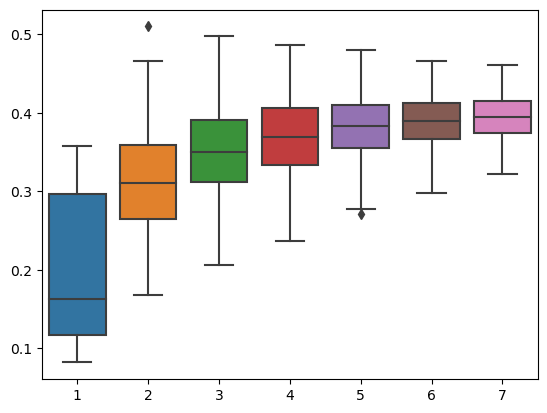

In [91]:
sns.boxplot(mme_size_to_results_df)

In [191]:

df_no_era = x_y_cv_expanded.loc[(x_y_cv_expanded["init_month"] == 10) & (x_y_cv_expanded["model"] != "ERA"), ['model', 'year', 'init_month', 'tt_11_a', 'rr_11_g']].reset_index(drop=True)
df_era = x_y_cv_expanded.loc[(x_y_cv_expanded["init_month"] == 12) & (x_y_cv_expanded["model"] == "ERA"), ['model', 'year', 'init_month', 'tt_11_a', 'rr_11_g']].reset_index(drop=True)
N = len(df_no_era["model"].unique().tolist())
model_to_error = {}
model_to_error['rr_11_g'] = {}
model_to_error['tt_11_a'] = {}

# calculate bias between each model and ERA
# current logic averages bias per year across all three features
for model in df_no_era["model"].unique().tolist():
    bias1 = np.array(df_no_era.loc[df_no_era["model"] == model, ['tt_11_a']]) -  np.array(df_era.loc[df_era["model"] == "ERA", ['tt_11_a']])
    bias2 = np.array(df_no_era.loc[df_no_era["model"] == model, ['rr_11_g']]) -  np.array(df_era.loc[df_era["model"] == "ERA", ['rr_11_g']])
    
    model_to_error['tt_11_a'][model] = bias1.flatten()
    model_to_error['rr_11_g'][model] = bias2.flatten()

#print(model_to_error['tt_11_a'])
# Create a DataFrame from the dictionary
df1 = pd.DataFrame(model_to_error['tt_11_a'])
df2 = pd.DataFrame(model_to_error['rr_11_g'])

# correlation matrix
correlation_matrix1 = df1.corr()
correlation_matrix2 = df2.corr()

correlation_matrix = (correlation_matrix1 + correlation_matrix2) / 2


In [193]:
metrics = []
correlations = []
for size in range(2,5):
    model_combinations = list(combinations([c for c in relevant_models if c != "ERA"], size))
    print(len(model_combinations))
    for i in range(0, len(model_combinations)):
        combi = list(model_combinations[i])
        mme = x_y_cv_expanded.loc[x_y_cv_expanded["model"].isin(combi)].assign(model="MME_{}".format("_".join(combi))).groupby(["model", "year", "init_month"]).mean().reset_index()
        x_y_cv_mme = pd.concat([mme, x_y_cv_expanded], ignore_index=True)
        res = forecast.kfold_cross_validation(x_y_cv_mme, model="MME_{}".format("_".join(combi)), init=10, no_of_features=3)
        #metric = pearsonr(res["yield anomaly [%]"], res["predicted"])[0]
        metric = r2(res["yield anomaly [%]"], res["predicted"])

        metrics.append(metric)
        corr = correlation_matrix.loc[correlation_matrix.index.isin(combi), combi].where(np.triu(np.ones(len(combi)), k=1).astype(bool)).stack().mean()
        correlations.append(corr)
    

55
165
330


In [194]:
metrics_to_correlation = pd.DataFrame(
    {'metrics': metrics,
     'correlation': correlations
    })
metrics_to_correlation.head()

,metrics,correlation
0,0.263425,0.634043
1,0.318897,0.478986
2,0.213110,0.616732
3,0.302889,0.659005
4,0.318730,0.734295


<Axes: xlabel='correlation', ylabel='metrics'>

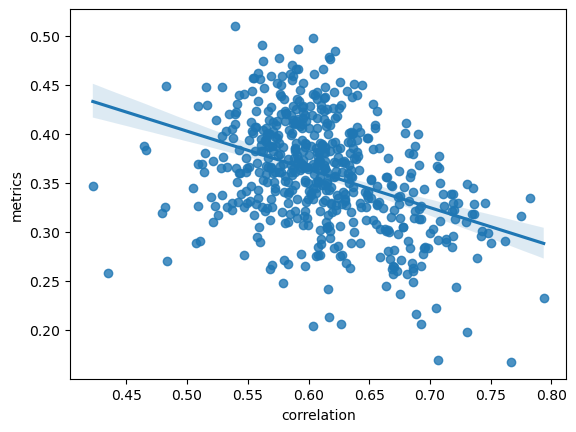

In [195]:
#sns.scatterplot(data=metrics_to_correlation, x="correlation", y="metrics")
sns.regplot(x = "correlation", y = "metrics", data = metrics_to_correlation)

In [224]:
mme = x_y_cv_expanded.loc[x_y_cv_expanded["model"].isin(["ECCC", "GFDL"])].assign(model="MME_{}".format("_".join(["ECCC", "GFDL"]))).groupby(["model", "year", "init_month"]).mean().reset_index()
x_y_cv_mme = pd.concat([mme, x_y_cv_expanded], ignore_index=True)
res = forecast.kfold_cross_validation(x_y_cv_mme, model="MME_{}".format("_".join(["ECCC", "GFDL"])), init=10, no_of_features=3)

# rmse
rmse = 100 * np.round(mse(res["yield anomaly [%]"], res["predicted"], squared=False), 3)
# r
r = np.round(pearsonr(res["predicted"], res["yield anomaly [%]"])[0], 2)

# coefficient of determination
r2 = np.round(r2_score(res["yield anomaly [%]"], res["predicted"]), 2)

print("rmse: {}; r: {}; R2: {}".format(rmse, r, r2))

rmse: 9.5; r: 0.73; R2: 0.51


<Axes: xlabel='year'>

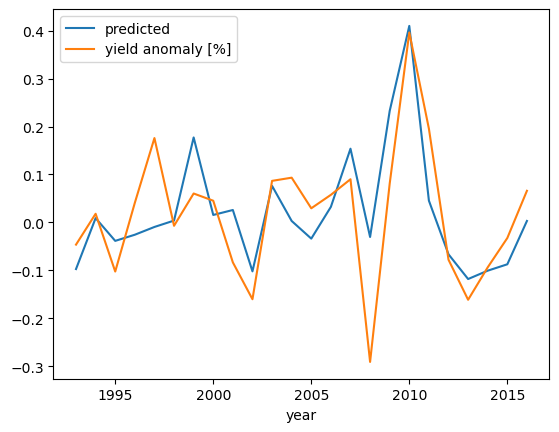

In [223]:
res.set_index("year").plot()